## Advanced CNN models
* AlexNet
    * first use of ReLU
    * used Norm layers
    * heavy data augmentation
    * dropout 0.5
    * batch 128
    * SGD momoentum 0.9
    * learning rate 1e-2, reduced by 10 manually when val acc plateaus
    * L2 weight decay 5e-4
    * 7 CNN ensembel : 18.2% -> 15.4%
  
* VGG
    * Small filters, Deeper network
    * more non-linerity & same # of params
    * Only use 3*3 Conv, stride1, pad1, max-pool 2
    * But, still many parameters used in fc layers

* GoogleNet
    * 22 layers
    * Efficient "Inception" module
        * apply parallel filter operations on the input from previous layer
        * Concatenate all filter outputs together depth-wise
        * Using bottle neck layer (1*1 conv layer with smaller depth)
    * No Fc layers
    * Only use 5mill params
  
* ResNet
    * Very deep networks using residual connection
    * Residual mapping
        * Skip-connection
        * Use layers to fit residual F(x) = H(x) - x instead of H(x) directly
        * and also using bottle-nect conv layer


### Resnet implementation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt
mps_device = torch.device("mps")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## ResNet Architecture
### conv3x3 and conv1x1 functions
* 자주 사용하게 될 1x1과 3x3 filter convolutional layer는 꼭 필요한 parameter인 in_planes, out_planes, stride만을 받아 convolutional layer module를 return해주는 함수를 만들어 사용

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

### Basic Block Module
* 2개의 3x3 convolution layer 와 skip connection 으로 구성된 BasicBlock module

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity # skip connection
        out = self.relu(out)

        return out

### Bottleneck Module
* 50개 이상의 layer를 가진 ResNet architecture에서 computational efficiency를 증가시키기 위해 3x3 convolution layer 앞뒤로 1x1 convolution layer를 추가한 Bottleneck module

In [5]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### ResNet Module

In [6]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [7]:
ResNet(block = BasicBlock, layers=[1,1,1,1], num_classes=1000, zero_init_residual=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [8]:
ResNet(block = Bottleneck, layers=[1,1,1,1], num_classes=1000, zero_init_residual=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
ResNet(block = Bottleneck, layers=[2,2,2,2], num_classes=1000, zero_init_residual=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True,
                                              num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() 

        # get the inputs
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [11]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False,
                                            num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [12]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False,
                                             num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc


In [13]:
def experiment(partition, args):
  
    net = ResNet(
        block=args.block,
        layers=args.layers,
        num_classes=args.out_dim,
        zero_init_residual= args.zero_init_residual
    )
    net.to(mps_device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adadelta':
        optimizer = optim.Adadelta(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adagrad':
        optimizer = optim.Adagrad(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'NAdam':
        optimizer = optim.NAdam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [14]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']
    del setting['block']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            # print(filename)
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [17]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "ResNet_BN_lr_optim_"

# ====== Model ====== #
# args.model_code = 'VGG11'

args.block = Bottleneck 
args.layers = [2,2,2,2]
args.out_dim = 10
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.0005

# ====== Optimizer & Training ====== #
# args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
# args.lr = 0.0015
args.epoch = 20

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'optim'
list_var1 = [0.00005, 0.0001, 0.005, 0.01]
list_var2 = ['SGD', 'RMSprop', 'Adam', 'NAdam']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='ResNet_BN_lr_optim_', block=<class '__main__.Bottleneck'>, layers=[2, 2, 2, 2], out_dim=10, zero_init_residual=True, l2=0.0005, epoch=20, train_batch_size=256, test_batch_size=1024, lr=5e-05, optim='SGD')
Epoch 0, Acc(train/val): 24.02/26.40, Loss(train/val) 2.05/2.01. Took 57.27 sec
Epoch 1, Acc(train/val): 32.65/34.23, Loss(train/val) 1.86/1.81. Took 56.91 sec
Epoch 2, Acc(train/val): 42.44/41.28, Loss(train/val) 1.62/1.63. Took 56.71 sec
Epoch 3, Acc(train/val): 48.88/44.59, Loss(train/val) 1.44/1.53. Took 56.80 sec
Epoch 4, Acc(train/val): 53.67/47.30, Loss(train/val) 1.30/1.46. Took 56.80 sec
Epoch 5, Acc(train/val): 58.94/48.89, Loss(train/val) 1.17/1.42. Took 57.02 sec
Epoch 6, Acc(train/val): 63.78/49.94, Loss(train/val) 1.04/1.40. Took 56.96 sec
Epoch 7, Acc(train/val): 69.67/49.71, Loss(train/val) 0.90/1.42. Took 57.39 sec
Epoch 8, Acc(train/val): 75.80/51.47, Loss(train/val) 0.74/1.40. Took 57.00 sec
Epoch 9, Acc(train/val): 81.80/47.89, Loss(train/val) 0

<AxesSubplot: xlabel='lr', ylabel='test_acc'>

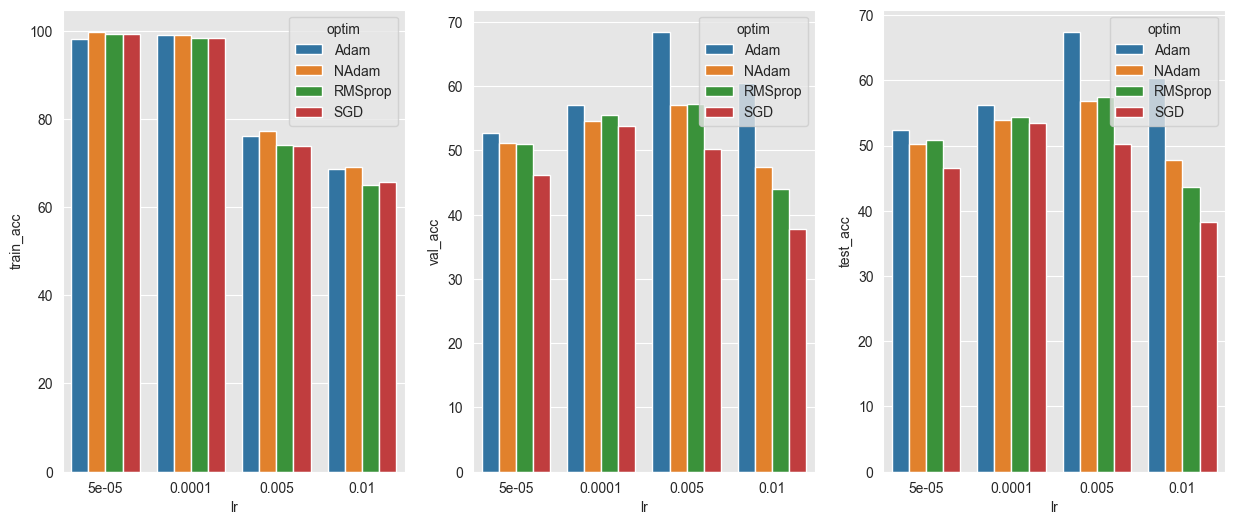

In [18]:
df = load_exp_result('ResNet_BN_lr_optim_')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.barplot(x='lr', y='train_acc', hue='optim', data=df, ax=ax[0])
sns.barplot(x='lr', y='val_acc', hue='optim', data=df, ax=ax[1])
sns.barplot(x='lr', y='test_acc', hue='optim', data=df, ax=ax[2])

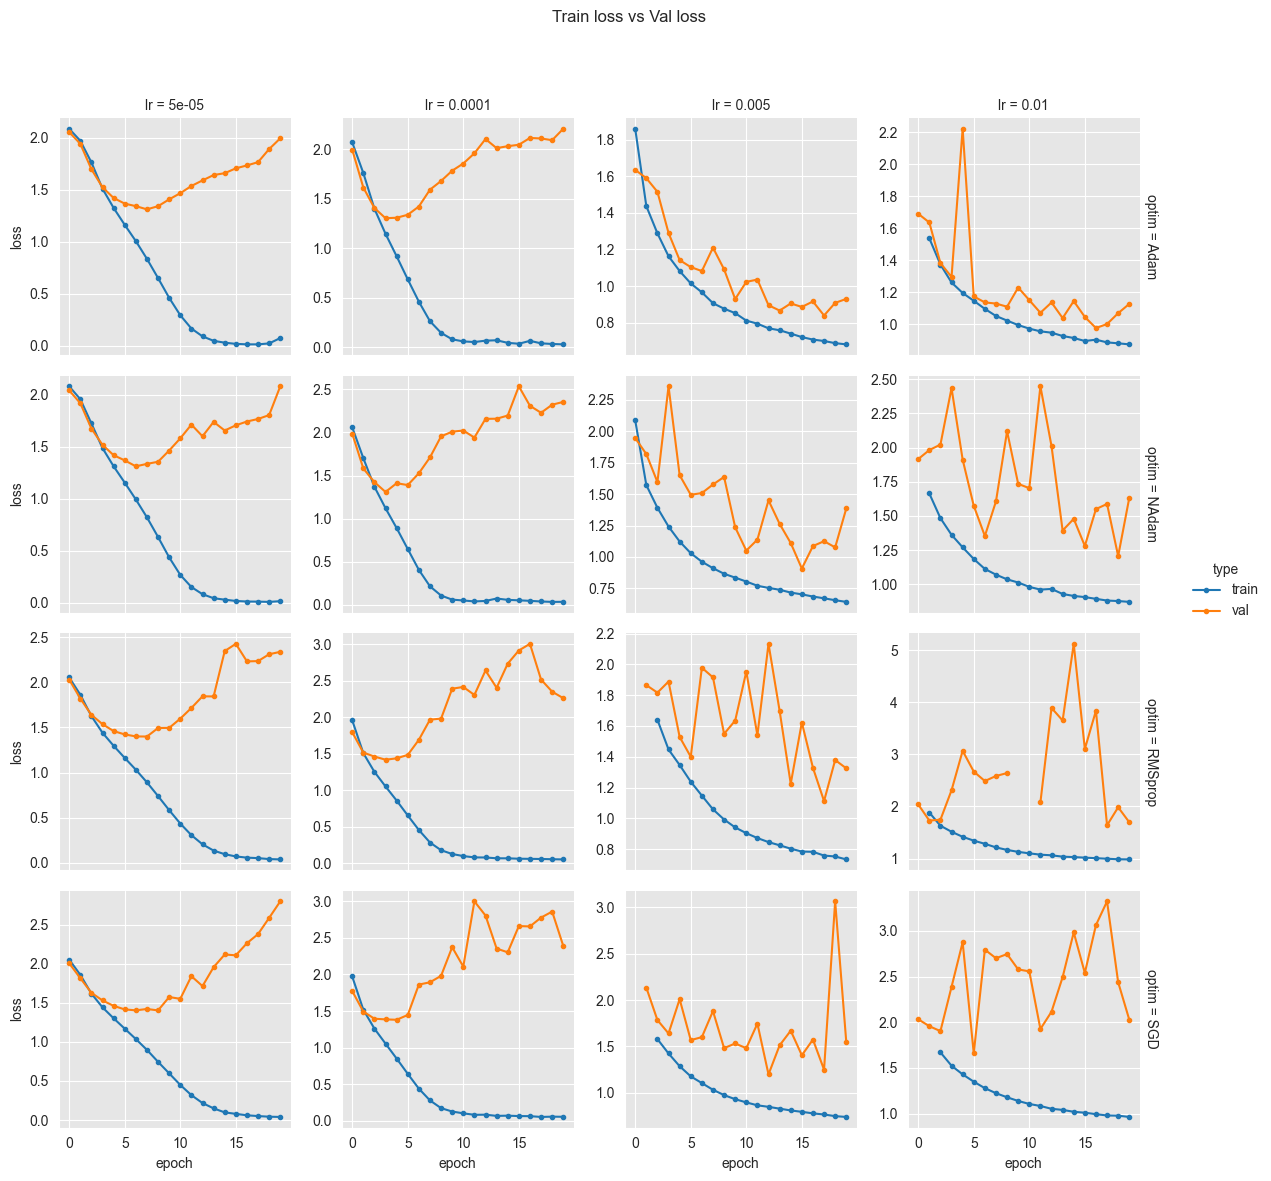

In [19]:
var1 = 'lr'
var2 = 'optim'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

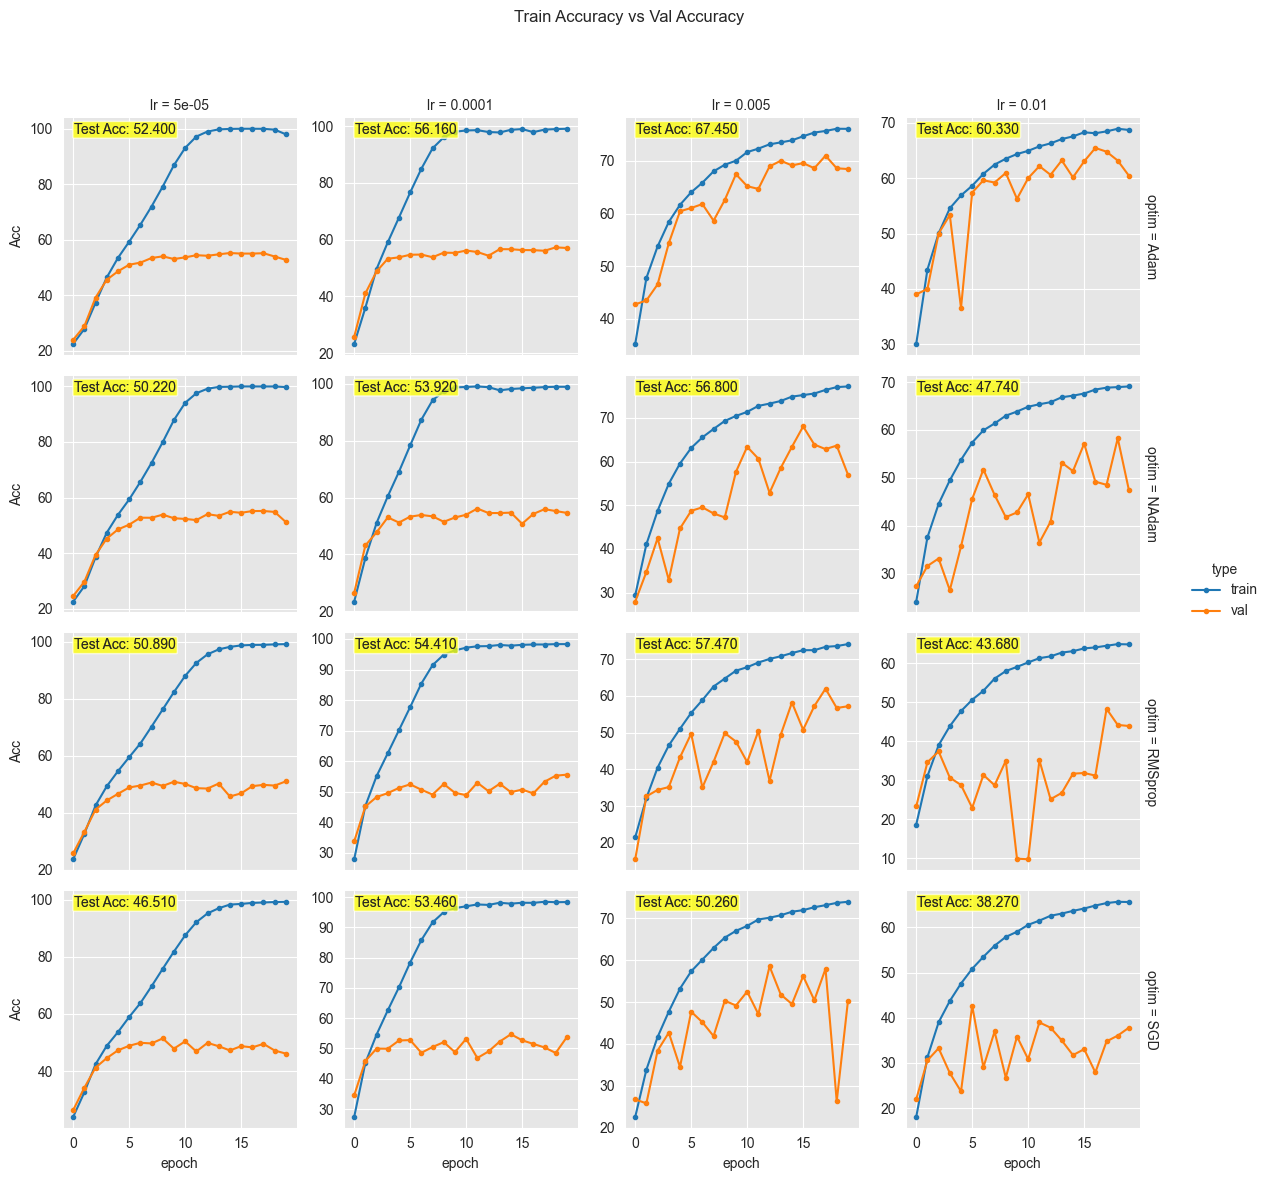

In [20]:
var1 = 'lr'
var2 = 'optim'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [22]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "ResNet_BN_layer_bs"

# ====== Model ====== #
# args.model_code = 'VGG11'

args.block = Bottleneck 
# args.layers = [1,1,1,1]
args.out_dim = 10
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.0001

# ====== Optimizer & Training ====== #
# args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0005
args.epoch = 25
args.optim = "Adam"
# args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'train_batch_size'
name_var2 = 'layers'
list_var1 = [128,256,512]
list_var2 = [[2,2,2,2], [3,4,6,3], [3,4,23,3]]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='ResNet_BN_layer_bs', block=<class '__main__.Bottleneck'>, out_dim=10, zero_init_residual=True, l2=0.0001, lr=0.0005, epoch=25, optim='Adam', test_batch_size=1024, train_batch_size=128, layers=[2, 2, 2, 2])
Epoch 0, Acc(train/val): 38.55/49.35, Loss(train/val) 1.68/1.45. Took 66.17 sec
Epoch 1, Acc(train/val): 56.99/61.13, Loss(train/val) 1.19/1.09. Took 66.02 sec
Epoch 2, Acc(train/val): 66.16/63.27, Loss(train/val) 0.95/1.02. Took 62.64 sec
Epoch 3, Acc(train/val): 72.29/66.19, Loss(train/val) 0.78/0.96. Took 62.64 sec
Epoch 4, Acc(train/val): 77.68/68.80, Loss(train/val) 0.62/0.93. Took 62.65 sec
Epoch 5, Acc(train/val): 82.42/69.34, Loss(train/val) 0.50/0.95. Took 64.71 sec
Epoch 6, Acc(train/val): 86.81/68.94, Loss(train/val) 0.38/1.01. Took 62.80 sec
Epoch 7, Acc(train/val): 89.39/70.03, Loss(train/val) 0.30/1.09. Took 65.25 sec
Epoch 8, Acc(train/val): 91.86/67.61, Loss(train/val) 0.23/1.19. Took 62.77 sec
Epoch 9, Acc(train/val): 93.46/70.15, Loss(train/val) 

<AxesSubplot: xlabel='layers', ylabel='test_acc'>

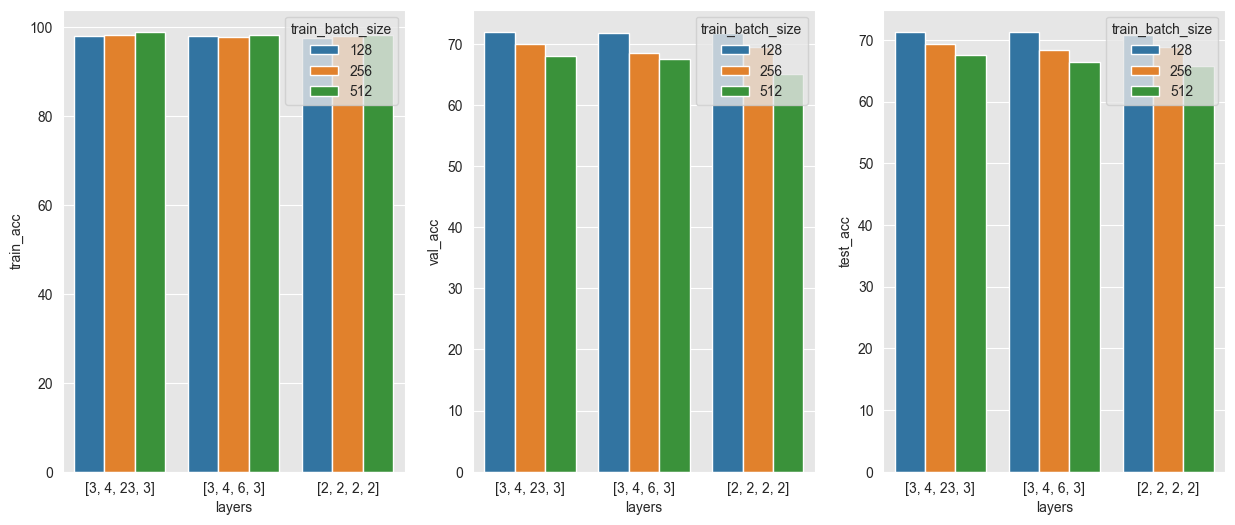

In [17]:
df = load_exp_result('ResNet_BN_layer_bs')
df['layers'] = df['layers'].astype(str)
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.barplot(x='layers', y='train_acc', hue='train_batch_size', data=df, ax=ax[0])
sns.barplot(x='layers', y='val_acc', hue='train_batch_size', data=df, ax=ax[1])
sns.barplot(x='layers', y='test_acc', hue='train_batch_size', data=df, ax=ax[2])

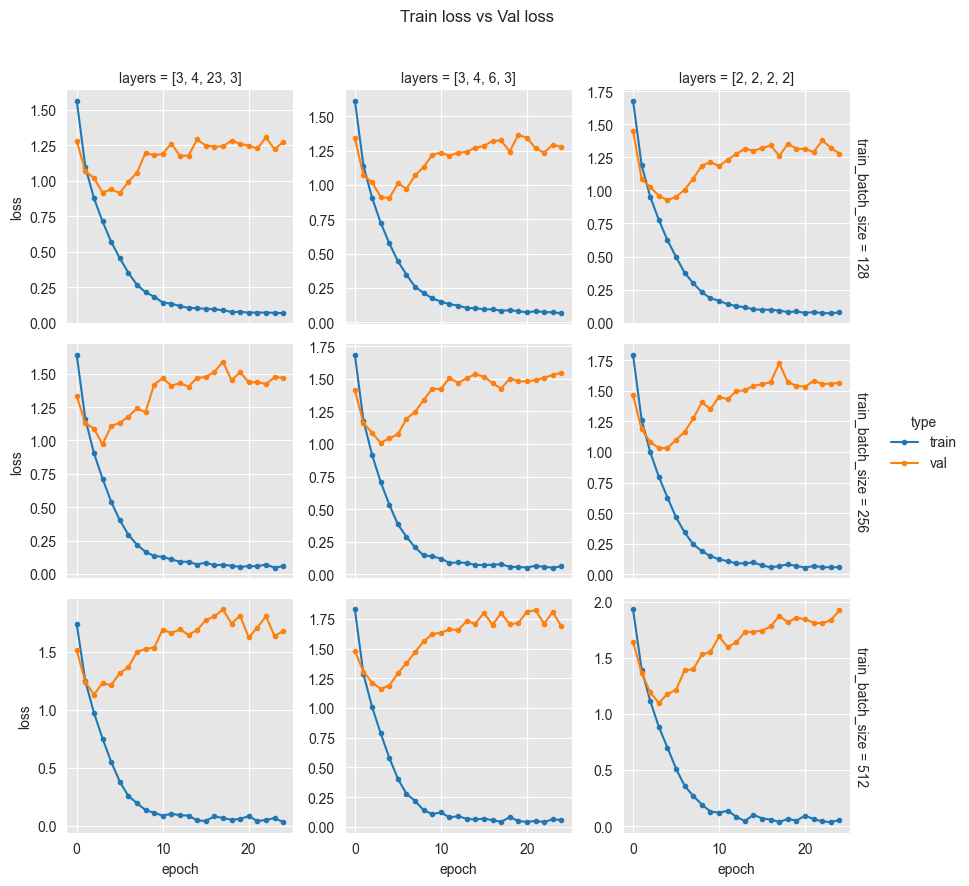

In [18]:
var1 = 'layers'
var2 = 'train_batch_size'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

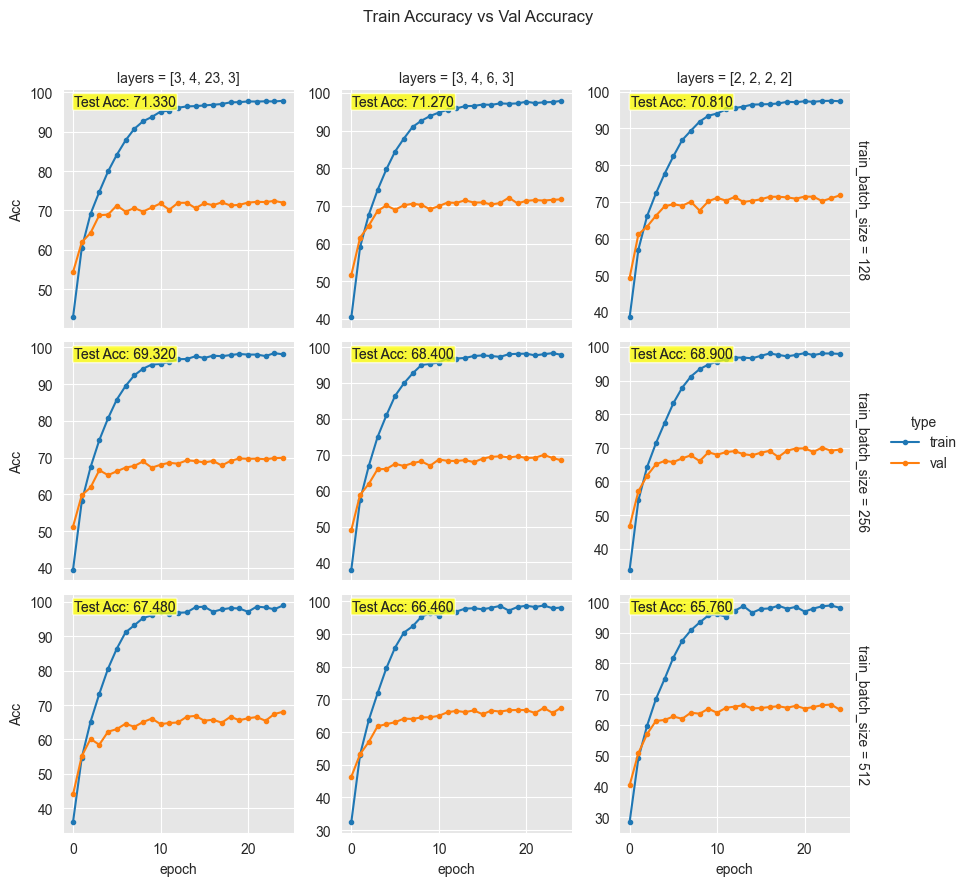

In [19]:
var1 = 'layers'
var2 = 'train_batch_size'
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [21]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def experiment_early_stop(partition, args):
  
    net = net = ResNet(
        block=args.block,
        layers=args.layers,
        num_classes=args.out_dim,
        zero_init_residual= args.zero_init_residual
    )
    net.to(mps_device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    patience = 20
    early_stopping = EarlyStopping(patience = patience, verbose = True)
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
        early_stopping(val_loss, net)

        if early_stopping.early_stop:
            print("Early stopping")
            break


    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [22]:
# epoch 과 batch size결정 
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "Resnet_early_stopping"

# ====== Model ====== #
args.block = Bottleneck 
args.layers = [3,4,23,3]
args.out_dim = 10
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.0001

# ====== Optimizer & Training ====== #
# args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0005
args.epoch = 30
args.optim = "Adam"
args.train_batch_size = 128
args.test_batch_size = 1024

setting, result = experiment_early_stop(partition, deepcopy(args))
save_exp_result(setting, result)


Epoch 0, Acc(train/val): 43.18/54.66, Loss(train/val) 1.56/1.27. Took 130.80 sec
Validation loss decreased (inf --> 1.268108).  Saving model ...
Epoch 1, Acc(train/val): 60.53/57.24, Loss(train/val) 1.10/1.19. Took 132.53 sec
Validation loss decreased (1.268108 --> 1.190177).  Saving model ...
Epoch 2, Acc(train/val): 68.45/66.31, Loss(train/val) 0.88/0.96. Took 131.29 sec
Validation loss decreased (1.190177 --> 0.962991).  Saving model ...
Epoch 3, Acc(train/val): 74.68/68.81, Loss(train/val) 0.72/0.92. Took 131.61 sec
Validation loss decreased (0.962991 --> 0.922675).  Saving model ...
Epoch 4, Acc(train/val): 79.78/67.52, Loss(train/val) 0.58/0.98. Took 130.06 sec
EarlyStopping counter: 1 out of 20
Epoch 5, Acc(train/val): 83.96/68.66, Loss(train/val) 0.45/0.98. Took 129.67 sec
EarlyStopping counter: 2 out of 20
Epoch 6, Acc(train/val): 87.67/69.42, Loss(train/val) 0.35/1.05. Took 130.10 sec
EarlyStopping counter: 3 out of 20
Epoch 7, Acc(train/val): 90.45/71.03, Loss(train/val) 0.2

In [23]:
df = load_exp_result('Resnet_early_stopping') 

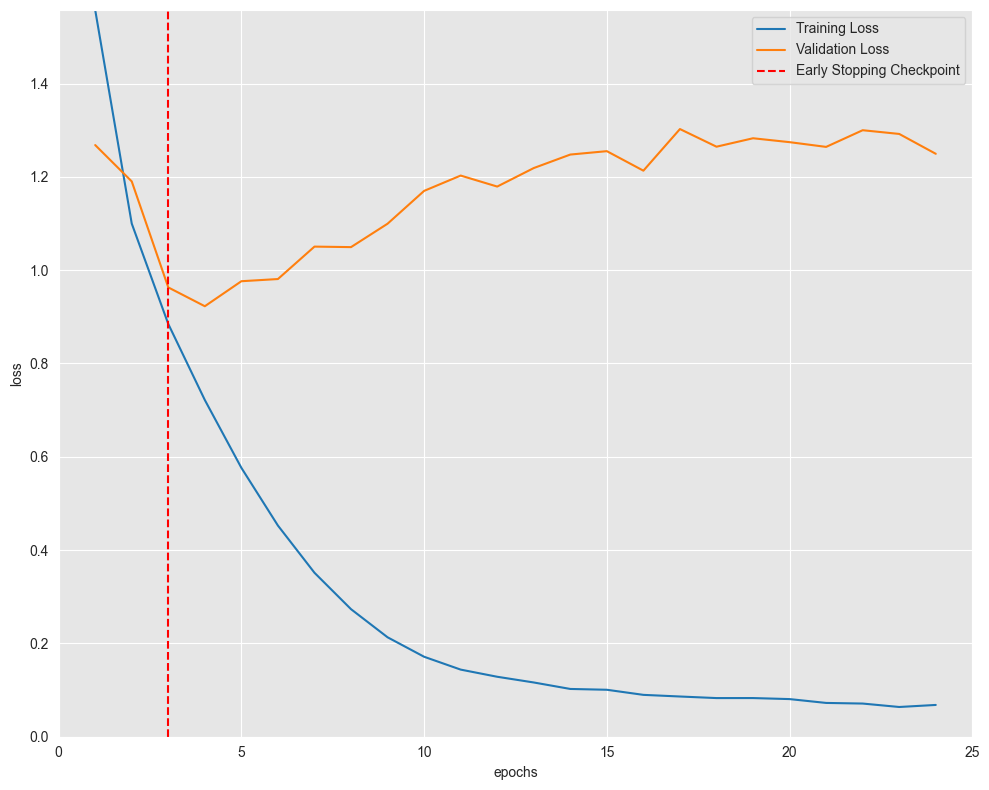

In [25]:
# 훈련이 진행되는 과정에 따라 loss를 시각화

train_loss = df['train_losses'].values[0]
valid_loss = df['val_losses'].values[0]

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss,label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = np.argmin(valid_loss)
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, max(train_loss)) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
print(df['test_acc'].values[0])

71.63
